In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
tr_df = train_df('OS Collected Data')
tr_df

,Class Path,Class
0,OS Collected Data\Normal\Normal 1.png,Normal
1,OS Collected Data\Normal\Normal 10.png,Normal
2,OS Collected Data\Normal\Normal 100.jpg,Normal
3,OS Collected Data\Normal\Normal 101.jpg,Normal
4,OS Collected Data\Normal\Normal 102.jpg,Normal
...,...,...
1942,OS Collected Data\Osteoporosis\Osteoporosis 95...,Osteoporosis
1943,OS Collected Data\Osteoporosis\Osteoporosis 96...,Osteoporosis
1944,OS Collected Data\Osteoporosis\Osteoporosis 97...,Osteoporosis
1945,OS Collected Data\Osteoporosis\Osteoporosis 98...,Osteoporosis


In [4]:
train_df, dummies_df = train_test_split(tr_df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(dummies_df, test_size=0.5, random_state=42)

In [5]:
batch_size = 16
img_size = (224,224)

tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

gen = ImageDataGenerator()


tr_gen = tr_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                 y_col='Class',batch_size=batch_size,
                                 target_size=img_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',batch_size=batch_size,
                                    target_size=img_size)

ts_gen = gen.flow_from_dataframe(test_df, x_col='Class Path',
                                y_col='Class',batch_size=batch_size,
                                 target_size=img_size,shuffle=False)

Found 1557 validated image filenames belonging to 3 classes.
Found 195 validated image filenames belonging to 3 classes.
Found 195 validated image filenames belonging to 3 classes.


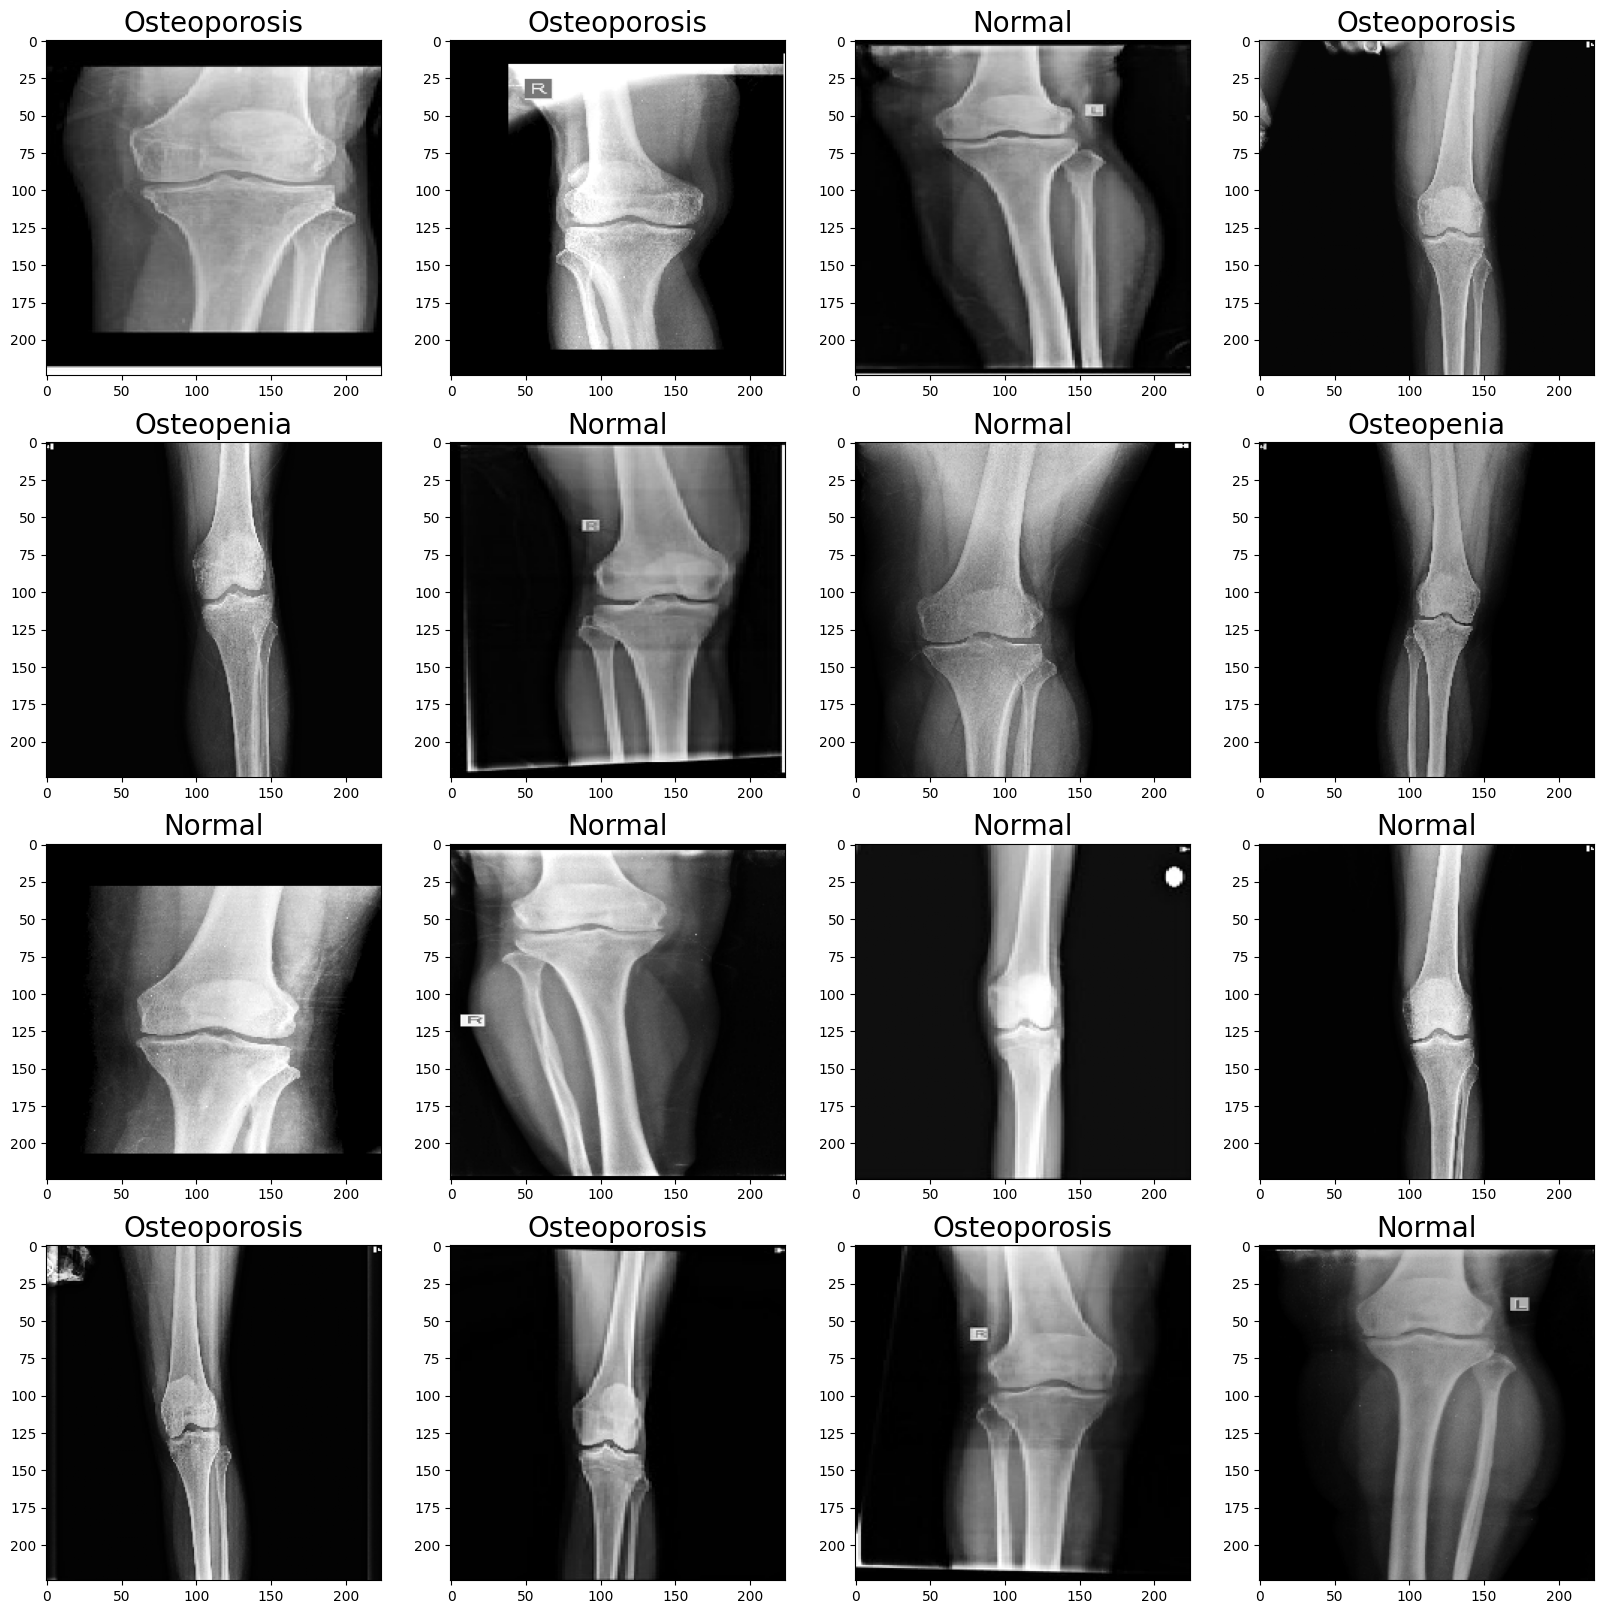

In [6]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
plt.show()

In [7]:
num_classes = len(classes)
num_classes

3

In [8]:
img_shape=(224,224,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(num_classes, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'binary_crossentropy',
              metrics= ['accuracy'])
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,139 (80.58 MB)

 Trainable params: 21,069,611 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [10]:
history = model.fit(tr_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - accuracy: 0.5147 - loss: 0.6304 - val_accuracy: 0.7179 - val_loss: 0.5198
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.8041 - loss: 0.3223 - val_accuracy: 0.7538 - val_loss: 0.3532
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8550 - loss: 0.2339 - val_accuracy: 0.8462 - val_loss: 0.2568
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9136 - loss: 0.1438 - val_accuracy: 0.8667 - val_loss: 0.3036
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.9136 - loss: 0.1497 - val_accuracy: 0.8769 - val_loss: 0.2591


In [11]:
model.evaluate(ts_gen, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 946ms/step - accuracy: 0.9003 - loss: 0.1775


[0.16695792973041534, 0.9025641083717346]

In [12]:
model.save("knee_Model.h5")

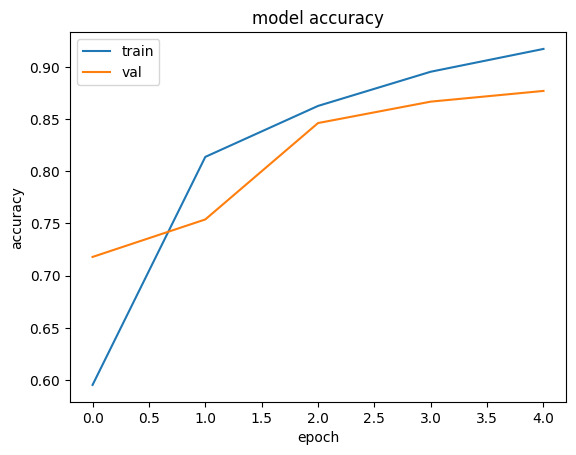

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

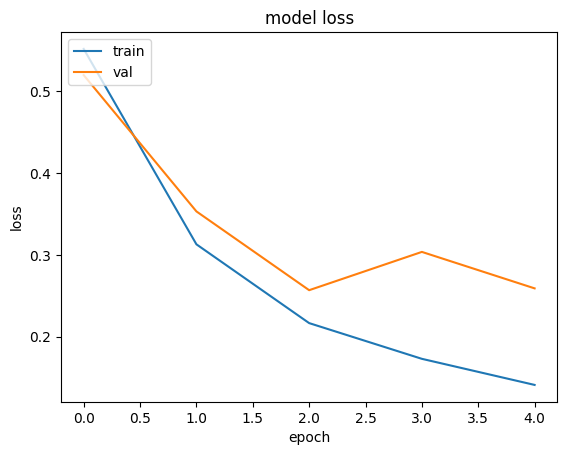

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
pred = model.predict(ts_gen)
pred = np.argmax(pred, axis=1)

labels = (tr_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 855ms/step


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_df['Class']
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.93      0.92      0.93        89
  Osteopenia       0.86      0.89      0.88        36
Osteoporosis       0.89      0.89      0.89        70

    accuracy                           0.90       195
   macro avg       0.89      0.90      0.90       195
weighted avg       0.90      0.90      0.90       195

Accuracy of the Model: 90.3%


In [17]:
classes=list(tr_gen.class_indices.keys())
print (classes)

['Normal', 'Osteopenia', 'Osteoporosis']


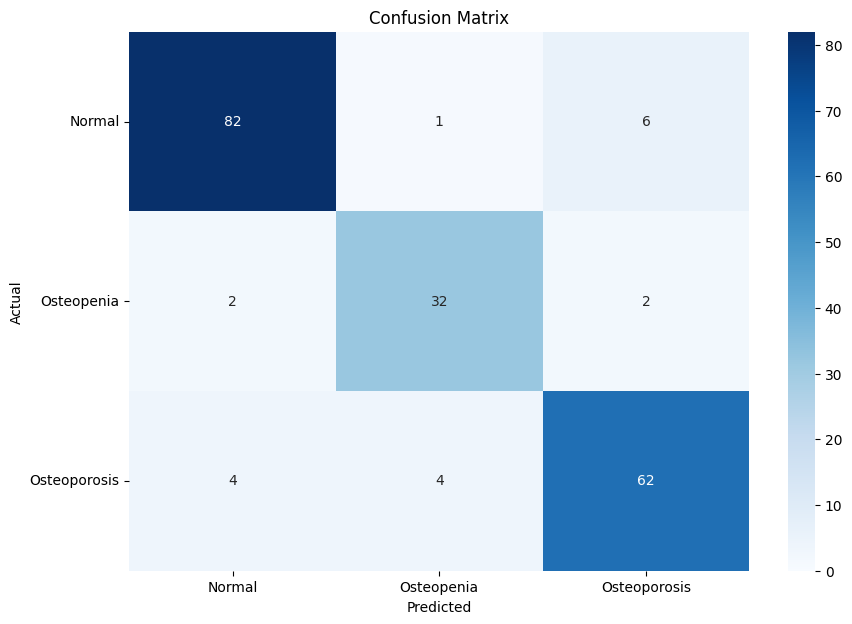

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_df['Class'].values
cm = confusion_matrix(y_true, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

num_classes = len(classes)

plt.xticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=0)
plt.yticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()